<a href="https://colab.research.google.com/github/sundarjhu/Astrostatistics2021/blob/main/Astrostatistics_Lecture14_20210601.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
seed = 20001
import numpy as np
from scipy.stats import expon
np.random.seed(seed)
scale = 3
x = expon.rvs(scale = scale, size = 10) #mean: scale. variance: scale**2
x

array([4.57225513, 0.88710949, 6.75265182, 2.37323278, 1.2924811 ,
       1.8693004 , 2.04175908, 6.89670467, 2.90285318, 3.76156058])

#Bootstrap illustration
##The sample 
##$x = [4.572, 0.887, 6.753, 2.373, 1.293, 1.869, 2.042, 6.897, 2.903, 3.762]$
##is drawn from an unknown distribution. 

##Use the bootstrap algorithm to estimate the population mean of this distribution.

Maximum number of unique 10-element samples possible from original dataset: 92378
Bootstrap estimate for the population mean: 3.333.
Bootstrap estimate of standard deviation on the population mean: 0.628.


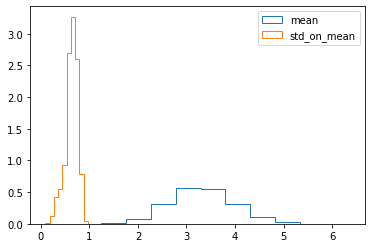

The 95% central confidence interval for the population mean is [2.15  4.646]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

scale = 3 #true mean of population (used to generate the data)
x = [4.572, 0.887, 6.753, 2.373, 1.293, 1.869, 2.042, 6.897, 2.903, 3.762]
N = len(x)
B = binom(2 * N - 1, N) #maximum number of unique N-element samples from x
print("Maximum number of unique {}-element samples possible from original dataset: {}".format(N, int(B)))

#Bootstrap sampling procedure
Bsamples = 100000
xx = np.random.choice(x, size = (10, Bsamples)) #This includes permutations of the same array. How do we fix that? [Homework!]
mean = xx.mean(axis = 0)
std_on_mean = xx.std(ddof = 1, axis = 0) / np.sqrt(N)
print("Bootstrap estimate for the population mean: {}.".format(np.round(mean.mean(), decimals = 3)))
print("Bootstrap estimate of standard deviation on the population mean: {}.".format(np.round(std_on_mean.mean(), decimals = 3)))
#Done bootstrap sampling, plot resulting sampling distribution

plt.hist(mean, histtype = 'step', label = 'mean', density = True)
plt.hist(std_on_mean, histtype = 'step', label = 'std_on_mean', density = True)
plt.legend(loc = 'best')
plt.show()
print("The 95% central confidence interval for the population mean is {}".format(np.round(CI, decimals = 3)))

# Two-sample $t$-test on independent and dependent/paired/matched/correlated samples.

> ### Assumptions:<br> - Samples are drawn from a Gaussian distribution.<br> - Sample sizes approximately equal.<br> - Samples have the same variance (relaxed versions exist: Welch's $t$-test).

## Independent samples

### Generate two independent samples from a Normal distribution

In [ ]:
from scipy.stats import norm
import numpy as np
N = 50; N1 = 50; N2 = 50
np.random.seed(seed)
#Notice the means are different by design!
x1 = norm.rvs(loc = 0.0, size = N); x2 = norm.rvs(loc = 1.0, size = N)

### Compute the $t$-statistic for the difference in means
#### $t = \displaystyle{\overline{x_1} - \overline{x_2}\over \sqrt{\displaystyle{\hat{\sigma_1^2}\over N} + \displaystyle{\hat{\sigma_2^2}\over N}}}$

In [ ]:
se1 = x1.std(ddof = 1) / np.sqrt(N) #standard error on sample mean of sample 1
se2 = x2.std(ddof = 1) / np.sqrt(N) #standard error on sample mean of sample 2
sed = np.sqrt(se1**2 + se2**2) #standard error on pooled sample
tstat = (x1.mean() - x2.mean()) / sed
#Total number of degrees of freedom in pooled sample is total number of points - 2
#      because two population means are estimated from the samples.
df = (N1 -1) + (N2 - 1)
print("The t-statistic is {} and has {} degrees of freedom".format(np.round(tstat, decimals = 3),df))

The t-statistic is -6.72 and has 98 degrees of freedom


### Determine $p$-value of the observed $t$-statistic

In [ ]:
from scipy.stats import t
alpha = 0.05

choice = input("Perform one-tailed test? [Y]/N: ")
if choice.upper() == 'Y':
    print("OK, performing one-tailed test...")
    if tstat < 0:
        pvalue = t.cdf(tstat, df)
        print("Observed t statistic is negative, performing left-tailed test")
        print("p-value for t <= observed value is ", np.format_float_scientific(pvalue, precision=2))
    else:
        pvalue = 1 - t.cdf(tstat, df)
        print("Observed t statistic is positive, performing right-tailed test")
        print("p-value for t >= observed value is ", np.format_float_scientific(pvalue, precision=2))
else:
    tstat_abs = np.abs(tstat)
    pvalue = t.cdf(-tstat_abs, df) + 1 - t.cdf(tstat_abs, df)
    print("OK, performing two-tailed test...")
    print("p-value for |t| >= observed value is ", np.format_float_scientific(pvalue, precision=2))

if pvalue <= alpha:
    print("Since p-value is <= alpha, the null hypothesis is rejected.")
else:
    print("Since p-value is > alpha, the null hypothesis cannot be rejected.")

Perform one-tailed test? [Y]/N: y
OK, performing one-tailed test...
Observed t statistic is negative, performing left-tailed test
p-value for t <= observed value is  6.03e-10
Since p-value is <= alpha, the null hypothesis is rejected.


### Try the same with `scipy.stats.ttest_ind` (two-tailed test)
#### p-value for one-tailed test should be half of that for a two-tailed test since the $t$ distribution is symmetric.

In [ ]:
from scipy.stats import ttest_ind
tstat, pvalue = ttest_ind(x1, x2, equal_var = True)
print("The observed t-statistic is", np.round(tstat, decimals = 3))
print("The corresponding p-value is ", np.format_float_scientific(pvalue, precision=2))


if pvalue <= alpha:
    print("Since p-value is <= alpha, the null hypothesis is rejected.")
else:
    print("Since p-value is > alpha, the null hypothesis cannot be rejected.")

The observed t-statistic is 2.31
The corresponding p-value is  2.3e-02
Since p-value is <= alpha, the null hypothesis is rejected.


## Dependent samples

### Generate two dependent samples

In [ ]:
np.random.seed(seed)
#x1: source + background with mean 0.5
#x2: background-subtracted data
x1 = norm.rvs(loc = 3.0, size = 50); x2 = x1 - norm.rvs(loc = 0.5, size = 50)
#Demonstrate that x1 and x2 are correlated
from scipy.stats import pearsonr
r, _ = pearsonr(x1, x2)
print("The two datasets have a Pearson r correlation coefficient of {}".format(np.round(r, decimals = 3)))

The two datasets have a Pearson r correlation coefficient of 0.68


### Compute the $t$-statistic for the difference in means
#### $t = \displaystyle{\overline{x_1}-\overline{x_2}\over \displaystyle{s_y\over \sqrt{N}}}$, where $s_y \equiv \sqrt{\displaystyle{1\over N-1}\Bigg[\displaystyle\sum\limits_{i=1}^N (x_{1,i}-x_{2,i})^2 - 
N(\overline{x_1}-\overline{x_2})^2
%\displaystyle{\Big(\displaystyle\sum\limits_{i=1}^N (x_{1,i}-x_{2,i})\Big)^2\over N}
\Bigg]}$

In [ ]:
from scipy.stats import ttest_rel
tstat, pvalue = ttest_rel(x1, x2)
print("The observed t-statistic is", np.round(tstat, decimals = 3))
print("The corresponding p-value is ", np.format_float_scientific(pvalue, precision=2))


if pvalue <= alpha:
    print("Since p-value is <= alpha, the null hypothesis is rejected.")
else:
    print("Since p-value is > alpha, the null hypothesis cannot be rejected.")

The observed t-statistic is 3.884
The corresponding p-value is  3.08e-04
Since p-value is <= alpha, the null hypothesis is rejected.
